# Day 3 the day we do things right! right? 

In order to do better I'm going to stop shooting in the dark and actuallly do some data analysis 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Ok so the first thing that im gonna do is try to make sense of how much impact each feature has in relation with the chance of someone surviving.
For that im going to create a function that will create a visualization of the amout of people that survived or died depending on the feature variance

In [17]:
def visualization(feature):
    survived = train_df[train_df['Survived']==1][feature].value_counts()
    died = train_df[train_df['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,died])
    df.index = ['Survived','Died']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

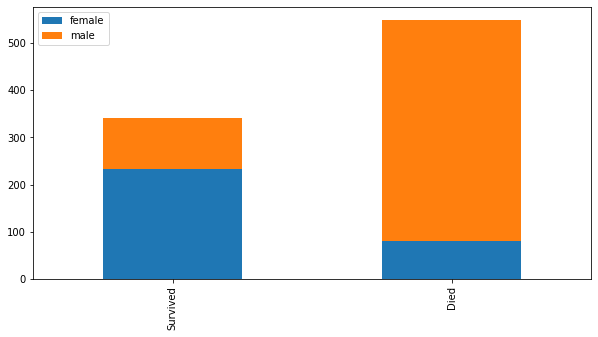

In [18]:
visualization('Sex')

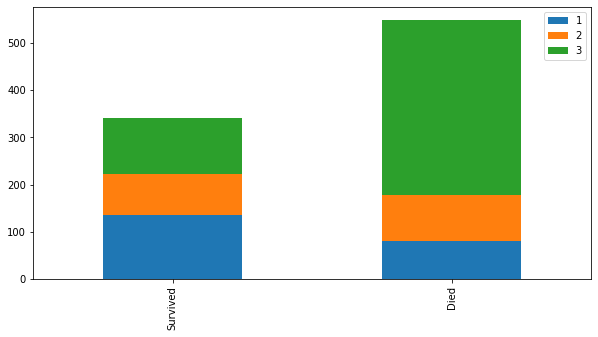

In [19]:
visualization('Pclass')

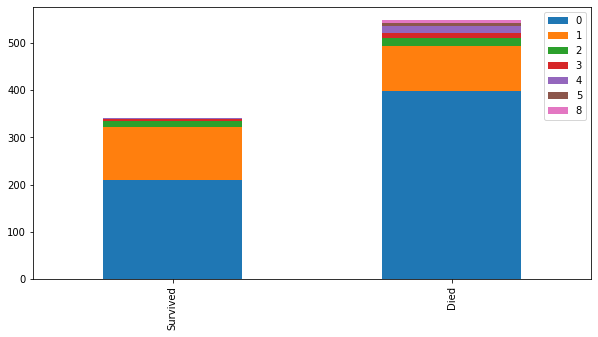

In [20]:
visualization('SibSp')

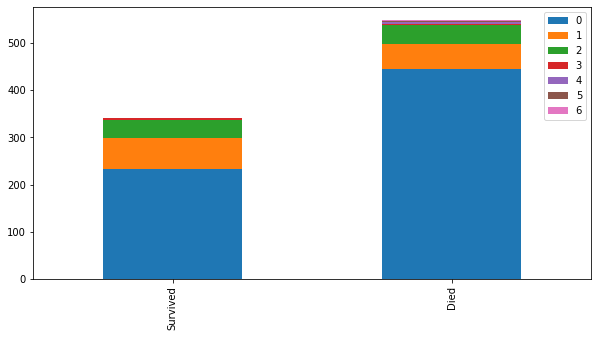

In [21]:
visualization('Parch')

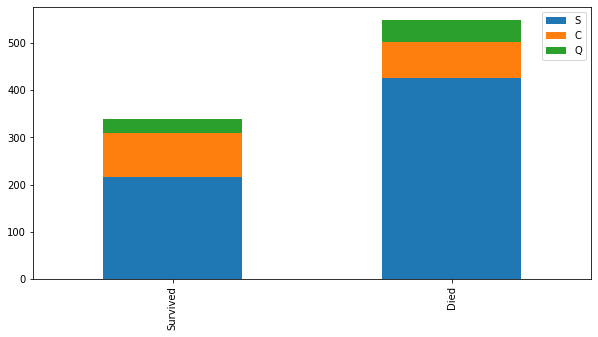

In [22]:
visualization('Embarked')

Well, this did not give me any new insights on the problem but at least  its an nice representation of the data. Now what i want to do is to try a idea that i read about on the kaggle forums, the idea was to get a measure of how much impact the title of a person had on their chances of survival.

BUT before we go and do all kinds of things let's first clean up our data.
There are a LOT of nan values so we should do something about it.
In past notebooks I used a function called clean in which I basically filled up the nan cells with the median value of the column and just set to 'U' the emabarked nan values, admittedly this was not the most scientific of aproches,but I really dont know what's the best course of accion in this situation.
So this time I'll try something diferent, firstly im gonna create a visualization of how much missing data there is.

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


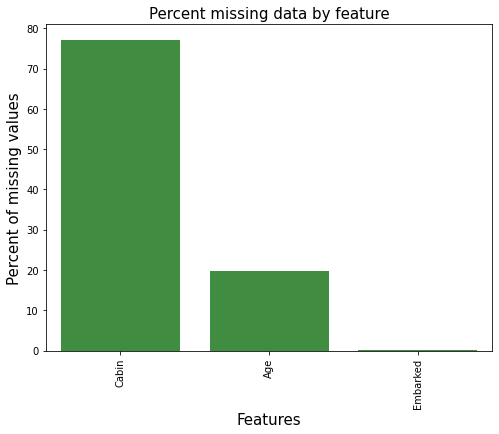

In [25]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

missingdata(train_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


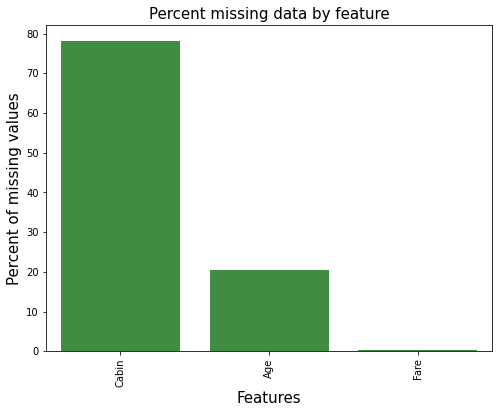

In [26]:
missingdata(test_df)

Now we can see that the column cabin has about 80% missing values so I think that the best thing we can do is just drop it compleatly, then for age, embarked and fare the percentage is significantly lower. For age im gonna fill the nan values with the mean value of the column. 

In [27]:
test_df['Age'].mean()

30.272590361445783

In [28]:
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

In [29]:
train_df.drop(['Cabin'], axis=1, inplace = True)
test_df.drop(['Cabin'],axis=1,inplace=True)

Im gonna give 'Fare' the same treatment that I gave age. It is only done in the test data frame because the train data frame has no missing values for fare


In [36]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

Now for embarked the problem is more complicated because there is (I think) no easy ways of filling up the nan values, but luckly there are pretty few of them so im just gonna filled them up with the frist entry that the data set gives since it probably won't have much of an affect on our ML model

In [37]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

With this we are finally free of missing values!

**Feature Engineering**

Basically we will try to trasnform our raw data into meaningful features.
We are going to use [cox box transformation](https://medium.com/@kangeugine/box-cox-transformation-ba01df7da884) but there are several feature engineering techniques that you can apply.

In [38]:
all_data=[train_df,test_df]

In [42]:
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

Finally we get to extract the titles from the passenger names

In [44]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Up next we'll separate the passengers by their age group

In [46]:
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

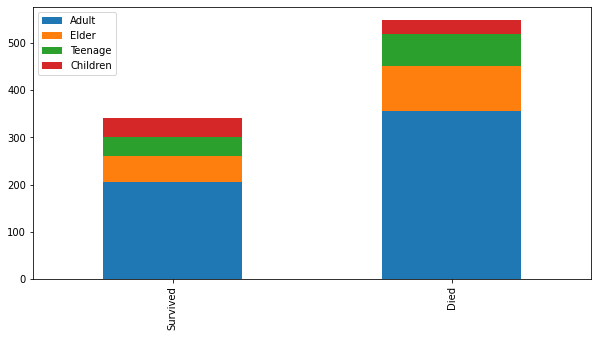

In [47]:
visualization('Age_bin')

For fare we'll do a similar thing and group them by how much they paid, the amouts that make for the treshholds may seem somewhat random but if you take a look at the data you'll see that those numbers are somewhat right for the jump in prices that the data shows

In [48]:
## create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

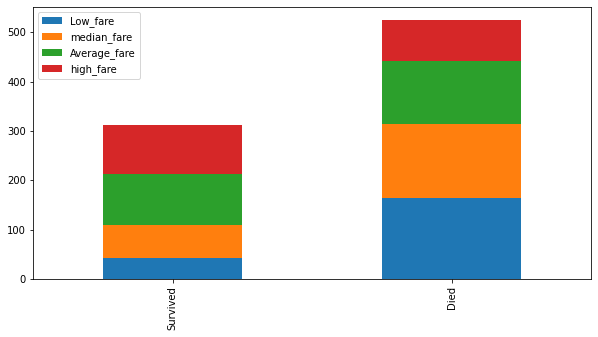

In [49]:
visualization('Fare_bin')

In [58]:
# for our own reference we'll make a copy of both DataSets and start working with the copy of the datasets
traindf = train_df
testdf = test_df

In [55]:
all_data = [train_df,test_df]
all_dat = [traindf,testdf]

Now we'll drop the columns(features) that are not really valuable any more

In [56]:
for dataset in all_dat:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [59]:
traindf.drop(['PassengerId'], axis=1, inplace = True)

so now we are ready to bash our hea... I mean try some ML models! The only thing that is left is to transform the categorical values into numerical ones.
I already did this in the last notebook but today im gonna use a build in function from pandas to make my life easier.

In [60]:
testdf.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_bin,Fare_bin
0,892,3,male,0,0,Q,1,Mr,Adult,Low_fare
1,893,3,female,1,0,S,2,Mrs,Elder,Low_fare


In [61]:
traindf.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_bin,Fare_bin
0,0,3,male,1,0,S,2,Mr,Adult,Low_fare
1,1,1,female,1,0,C,2,Mrs,Adult,high_fare


In [62]:
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                                  prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [63]:
testdf = pd.get_dummies(testdf, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                                prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [64]:
testdf.head()

,PassengerId,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_type_Children,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
1,893,3,1,0,2,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0
2,894,2,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,895,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
4,896,3,1,1,3,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0


In [67]:
traindf.head()

,Survived,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_type_Children,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,0,3,1,0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
1,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,1,3,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0


Ok now we'll use my favorite type of data visualization Heat maps

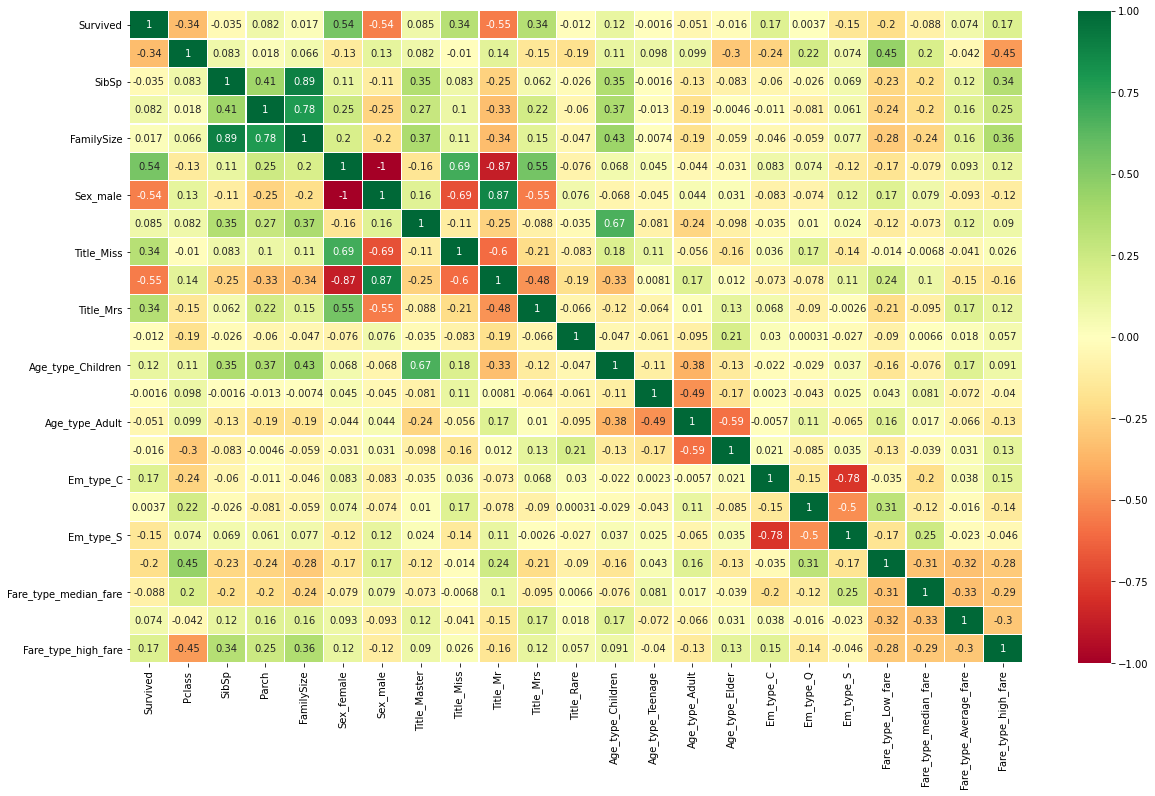

In [68]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

NOW we can really tell whats going on, kinda.

Interpreting The Heatmap The first thing to note is that only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings. Before understanding the plot, let us see what exactly correlation is.

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between SibSp and Parch i.e 0.41. So we can carry on with all features.

This is it for today im dead and I really need some rest I'll leave links to all the pleaces were I got information because if you didn't notice there is no way I come up with everything in this notebook, I took a lot of inspiration from many sorces. BYE.

**List of links**


*   https://www.kaggle.com/vinothan/titanic-model-with-90-accuracy
*   https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score
*   https://www.youtube.com/watch?v=3eTSVGY_fIE&list=LL&index=2
*   https://www.youtube.com/watch?v=pUSi5xexT4Q
*   https://www.kaggle.com/c/titanic/discussion/57447






